# Monitoring and Predicting Elasticity in Kubernetes

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import datetime
import json
import scipy.signal as ss
import math

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

import seaborn as sns
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(11, 4)})

# Introduction

## Goal of this project

This project has two main goals:

### 1. Monitoring Kubernetes:
Investigating ways to monitor Kubernetes in order to get information about the configuration of the deployed Software system at runtime. In particular, we are interested how many pods of each service are running and to which compute nodes they are scheduled. 

### 2. Predicting reconfigurations:
Learning behavioral patterns of Kubernetes in order to be able to predict reconfigurations, such as elastic rescaling, i.e. addition or removal of pods of specific services.

## Background
The main motivation for this work, is to provide information about the current configuration of the deployed system to an online model checker that verifies the correctness of every new system configuration. 
In a second step, the prediciton could be used to precompute model checking results at times where the model checker would otherwise be idle.

## Setup
All parts of the project were tested on a local Kubernetes cluster run on [Minikube](https://kubernetes.io/docs/tasks/tools/install-minikube/). As currently the support for running multi node clusters locally is very limited, all experiments were run in a setup with only one compute node. The virtual machine running the compute node had access to the following resources:

* 6 cores
* 8 GB RAM
* 32 GB disk storage

Testing similar solutions on clusters with multiple nodes and more compute power would be an interesting future extension.

### Example application
As example application that is deployed on Kubernetes I used a Google demo application which implements an online shop where users can browse items, add them to the cart, and purchase them. Code, build and deployment instructions can be found [here](https://github.com/GoogleCloudPlatform/microservices-demo).
The application consists of 10 different microservices. The following two microserveices are of importance for the experiments run in this project:

##### Frontend
Exposes an HTTP server to serve the website. 

##### Loadgenerator
Continuously sends requests imitating realistic user shopping flows to the frontend. Each pod running the loadgenerator service simulates the behavior of 10 users, which continuously browse items, add them to the cart, and perform purchases.

## Elastic rescaling
Changes in the input load, can be simulated by rescaling the number of loadgenerator pods. For example, the arrival of 10 new users is modelled by adding one loadgenerator pod.

In order to experiment with elastic rescaling, the number of frontend pods was dynamically controlled using a Kubernetes [horizontal pod autoscaler](https://kubernetes.io/docs/tasks/run-application/horizontal-pod-autoscale/) which automatically adds or removes pods based on observed CPU utilization. The autoscaler was configuread to schedule between 1 and 10 frontend pods and to add more pods whenever the observed CPU usage of the existing pods is more than 30%. This relatively low threshold was chosen in order to be able to observe more rescaling events in the generated outputs.

# 1. Monitoring Kubernetes

There are many existing tools for monitoring systems deployed on Kubernetes. Tools like [Prometheus](https://prometheus.io/docs/introduction/overview/) for example allow for the collection of various system statsitics.

However, as it turns out for our purposes even the information logged regurlaly by Kubernetes itself is sufficient. Various events such as the creation of pods, the deletion of pods, and the scheduling of pods to compute nodes are written to a log. Per default, all events are retrievable for one hour after their creation.

Events can be retrieved using the `kubectl` tool, the Kubernetes tool used for controlling Kubernetes cluster. The following image shows an extract of the output of running 
`kubectl get events` after the creation and deletion of some loadgenerator pod:

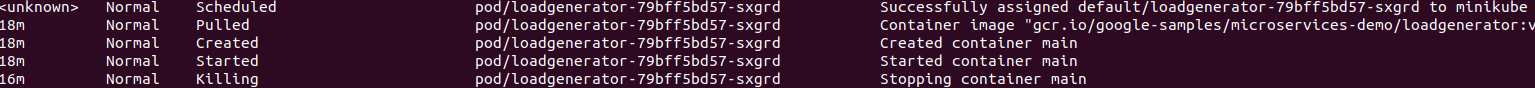

In [2]:
from IPython.display import Image
Image("./events.png")


For automatic processing a list of events can also be extracted as json files.

For the experiments in this project I wrote a python [script](https://github.com/ssallinger/runtimeVerification/blob/master/event_scraper.py) that retrieves all events and writes them to a file every 30 minutes.

### Generating traces
The following functions take Kubernetes events and construct corresponding traces and time series. See part 2 of the project for example usages.

The following function reads a list of events form a file and creates a dataframe containing pod creation and removal events:

In [3]:
def eventsToTrace(filnames):
    trace_dict = {}

    for file in filenames:
        with open(file) as events_file:
            events = json.load(events_file)
            for e in events['items']:
                if(e['reason']=='Created' or e['reason']=='Killing'):
                    time = datetime.datetime.strptime(e['firstTimestamp'], "%Y-%m-%dT%H:%M:%SZ")
                    trace_dict[e['metadata']['uid']] = [time, e['metadata']['name'], e['metadata']['name'].partition('-')[0], e['reason']]


    trace = pd.DataFrame.from_dict(trace_dict, orient='index')
    trace.columns = ['time', 'name', 'podType', 'event']
    trace.sort_values(by=['time'], inplace=True)

    return trace

The following function takes a trace and creates a time series that states the number of frontend and loadgenerator pods every minute:

In [4]:
def traceToTimeseries(trace_p):
    matrix = pd.DataFrame(columns = ['time', 'nrLoadgenerators', 'nrFrontends'])
    stepSize = datetime.timedelta(seconds=60)
    # sort trace by time
    trace_p.sort_values(by=['time'], inplace=True)
    # assumption: starting from 1,1 config
    # first row: all 1, then increment gradually 
    firstTs = trace_p['time'].iloc[0]
    lastTs = trace_p['time'].iloc[-1]
    
    currentTime = firstTs - stepSize
    #print('start:')
    #print(currentTime)
    nrFrontends = 1
    nrLoadgenerators = 1
    matrix = matrix.append(pd.Series([currentTime, nrLoadgenerators, nrFrontends], index=matrix.columns), ignore_index=True)
    idx = 0


    # walk over trace + evaluate change at every step
    while(currentTime <= lastTs + stepSize):
        while(idx < len(trace_p) and trace_p['time'].iloc[idx] <= currentTime):
            if(trace_p['podType'].iloc[idx] == 'frontend' and trace_p['event'].iloc[idx] == 'Killing'):
                nrFrontends = nrFrontends - 1
            if(trace_p['podType'].iloc[idx] == 'frontend' and trace_p['event'].iloc[idx] == 'Created'):
                nrFrontends = nrFrontends + 1
            if(trace_p['podType'].iloc[idx] == 'loadgenerator' and trace_p['event'].iloc[idx] == 'Killing'):
                nrLoadgenerators = nrLoadgenerators - 1
            if(trace_p['podType'].iloc[idx] == 'loadgenerator' and trace_p['event'].iloc[idx] == 'Created'):
                nrLoadgenerators = nrLoadgenerators + 1
            idx = idx + 1
        
        currentTime = currentTime + stepSize
        matrix = matrix.append(pd.Series([currentTime, nrLoadgenerators, nrFrontends], index=matrix.columns), ignore_index=True)

    return matrix


# 2. Predicting reconfigurations:

The goal of this part of the project is to build a machine learning model for predicting Kubernetes reconfigurations.
Given the somehow limited experimental setup (single node, restricted compute resources), I decided to focus on the following question: 

**Given the temporal history of the load and the number of frontends, can we predict how many frontend pods will be running at the next point in time?**

The first challenge was to construct an appropriate training data set. I created such a data set by monitoring the behavior of the Minikube cluster running the online shop application when confronted with typical load.

## Modelling the load

In order to be able to model realistic input load, I was looking for a way to estimate how many users typically visit online shops over the course of time. To this means, I used an external data set that contains Google Analytics data from the Google Merchandise Store, an ecommerce store selling Google branded merchandise. 
A detailed description of the data set and instructions how to retrieve the data can be found [here](https://www.kaggle.com/bigquery/google-analytics-sample).

I extracted a table from the data set with an entry for every newly started user session in the month of July 2017.

In [5]:
data = pd.read_csv("data.csv", index_col=0) 
data['visitStartTime'] = pd.to_datetime(data['visitStartTime'],unit='s')
data['date'] =  data['visitStartTime'].apply(lambda x: pd.Timestamp.to_pydatetime(x).date())
data['hour'] =  data['visitStartTime'].apply(lambda x: pd.Timestamp.to_pydatetime(x).replace(minute=0, second=0))

data.head()

,visitStartTime,continent,country,date,hour
0,2017-07-01 07:00:05,Americas,United States,2017-07-01,2017-07-01 07:00:00
1,2017-07-01 07:01:53,Asia,Philippines,2017-07-01,2017-07-01 07:00:00
2,2017-07-01 07:02:25,Americas,United States,2017-07-01,2017-07-01 07:00:00
3,2017-07-01 07:02:29,Americas,United States,2017-07-01,2017-07-01 07:00:00
4,2017-07-01 07:02:31,Asia,Philippines,2017-07-01,2017-07-01 07:00:00


In [6]:
data.shape

(71812, 5)

In order to use this data for the simulation, I computed the number of user sessions per hour. While for our applicaiton, it might make more sense to simulate how many users arrive every second or minute, the user numbers in the data sets where comparably low. Hence counting the users per hour yielded a more interesting pattern of user numbers.


In [7]:
ts = data.groupby(['hour', 'date']).count()['visitStartTime']

The plot of the data shows strong daily and weekly seasonality. There is clearly less load on weekends and during the night.

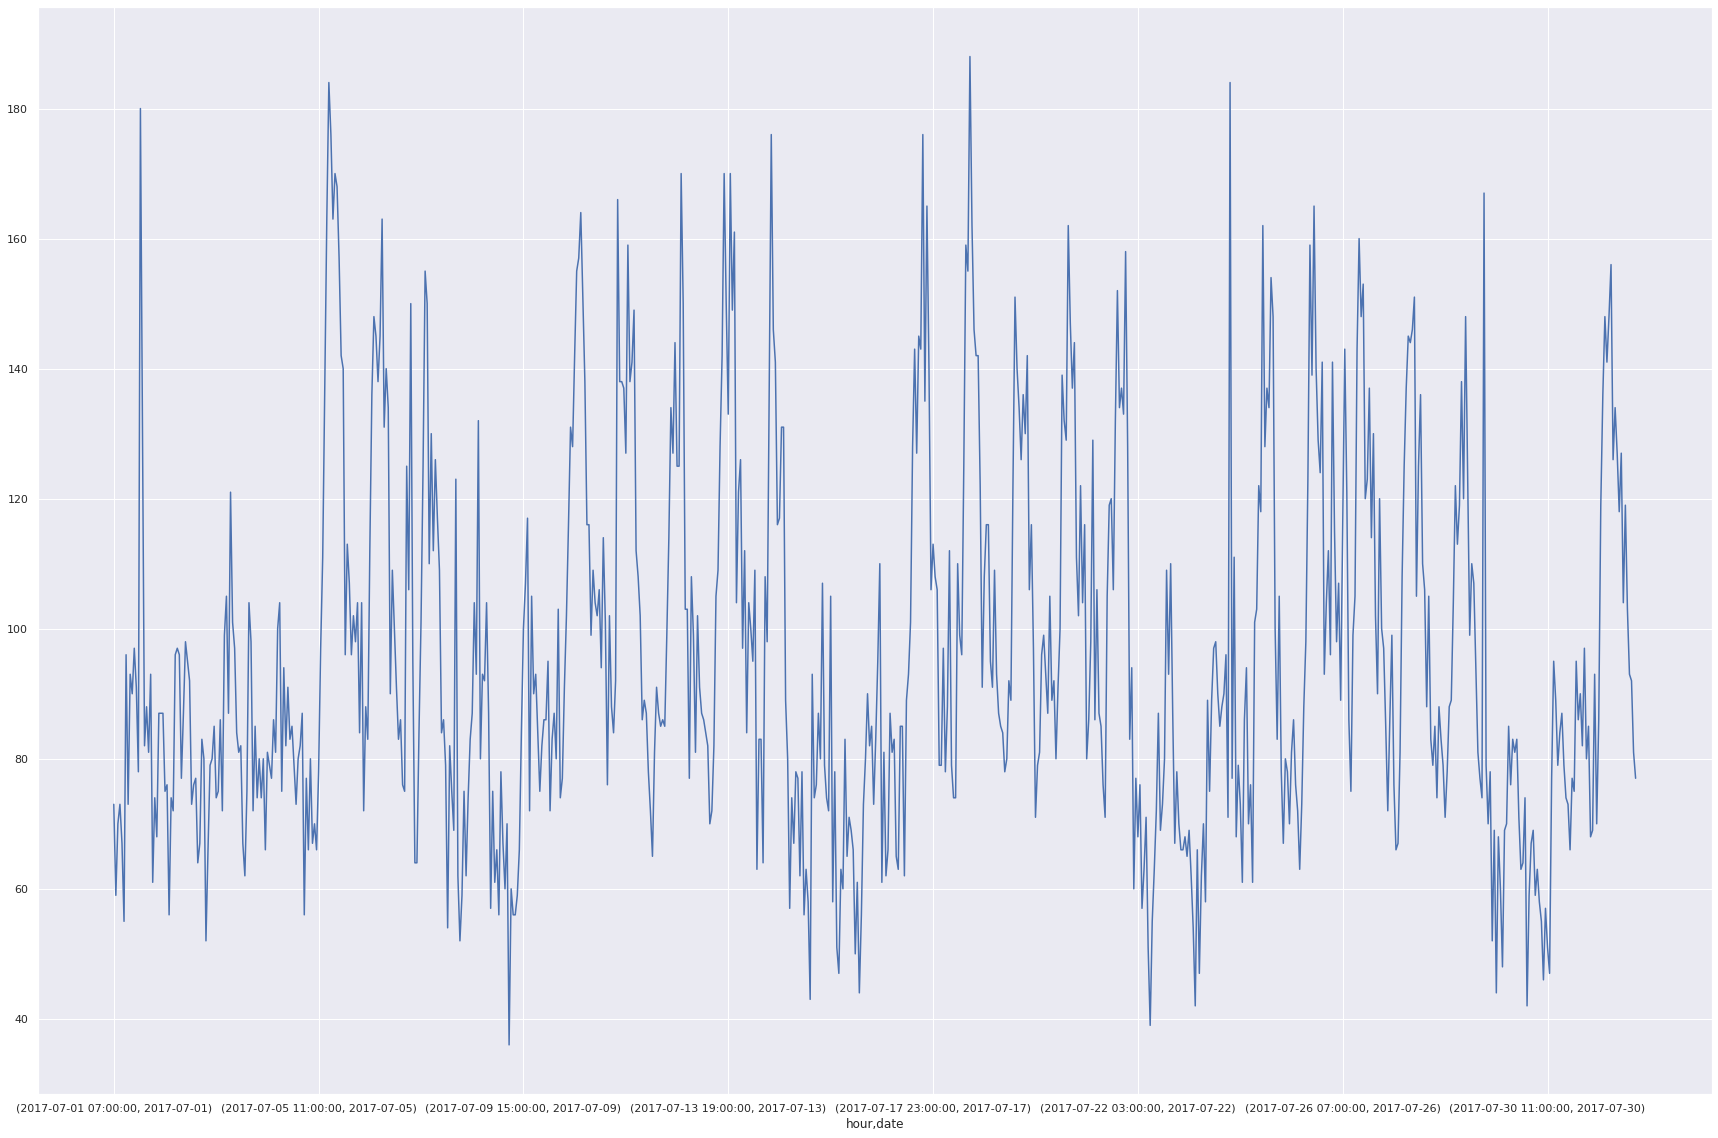

In [8]:
ts.plot(figsize=(30,20))
plt.show()

As in our setup one load generator simulates 10 users we rescale the data:  

In [9]:
ts_scaled = ts//10
#ts_scaled.to_csv('load.csv', index=False)

## Running the simulation

The load numbers generated like this were used in an experiment where the load is adapted every minute. That is, 1 hour in real time was simualted in 1 mintue simulation time. This allowed simulating the user data of one month in one day. 

The script that adapts the load every minute can be found [here](https://github.com/ssallinger/runtimeVerification/blob/master/loadcontroller.py).

## Processing simulation results

As described in Section 1, we first use `kubectl get events` to monitor the system and then generate the corresponding trace:

In [10]:
filenames = []

for i in range(1, 31):
    filenames.append('data/eventspart' + str(i) + '.txt')

trace = eventsToTrace(filenames)

#truncate parts before and after simulation
trace = trace[trace['time'] > datetime.datetime(2020, 9, 26, 14, 15)]
trace = trace[trace['time'] < datetime.datetime(2020, 9, 27, 3, 0)]

trace.head()

,time,name,podType,event
ba2ad388-374d-44f6-9a1b-961f0ea60200,2020-09-26 14:16:01,loadgenerator-79bff5bd57-lf2r8.16385b08d89b2303,loadgenerator,Created
f30e145a-c883-4c06-881b-f1d6674d6219,2020-09-26 14:16:01,loadgenerator-79bff5bd57-5vstf.16385b08d8a3dbed,loadgenerator,Created
308d1ed1-4ce1-4b1e-812f-5f57c0fa6006,2020-09-26 14:17:00,loadgenerator-79bff5bd57-5vstf.16385b16ae01aebb,loadgenerator,Killing
3f9eedcd-fc67-43c2-b0f2-ab09c2c63e3d,2020-09-26 14:17:17,frontend-5fcb8cdcdc-zbpr7.16385b1a8a38d1c1,frontend,Created
96746f22-a337-4986-a062-7ca3cfa45d42,2020-09-26 14:18:01,loadgenerator-79bff5bd57-2ld9p.16385b24df9cd32b,loadgenerator,Created


In the next step we transform the trace into a time series with one entry per minute:

In [11]:
matrix = traceToTimeseries(trace)
matrix = matrix.set_index('time')
matrix['nrFrontends'] = matrix['nrFrontends'].astype(int)
matrix['nrLoadgenerators'] = matrix['nrLoadgenerators'].astype(int)
matrix.head()

,nrLoadgenerators,nrFrontends
time,,
2020-09-26 14:15:01,1,1
2020-09-26 14:16:01,1,1
2020-09-26 14:17:01,3,1
2020-09-26 14:18:01,2,1
2020-09-26 14:19:01,3,2


Before building a model, let us take a closer look at the generated data. It can be observed that Kubernetes does not immediately create new frontend pods in reation to short load peaks which causes a relatively low correlation between the number of loadgenerators and the number of frontend pods. Furthermore, it can be observed that Kubernetes adapts the number of frontend with a certain delay.

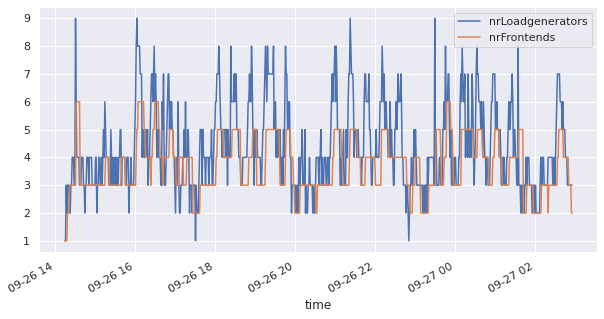

In [12]:
matrix.plot(y=['nrLoadgenerators', 'nrFrontends'], figsize=(10,5), grid=True)
plt.show()

Correlation between number of loadgenerators and number of frontends:

In [13]:
matrix["nrFrontends"].corr(matrix["nrLoadgenerators"], method='spearman')

0.5446986898674924

In order to see whether the number of frontends depends on the number of loadgenerators with some lag, we compute sample crosscorrelation. It turns that the strongest correlation of 0.729 is between the number of frontends at time i and the number of loadgenerators at time i-3.

maximal correlation:  0.729049884471886
lag:  -3


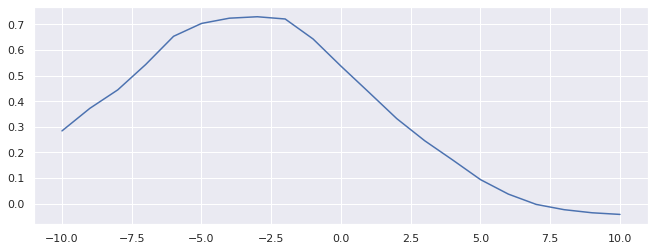

In [14]:
# ccf
def ccf(x, y, lag_max = 10):

    result = ss.correlate(y - np.mean(y), x - np.mean(x), method='direct') / (np.std(y) * np.std(x) * len(y))
    length = (len(result) - 1) // 2
    lo = length - lag_max
    hi = length + (lag_max + 1)

    return result[lo:hi]


c = ccf(matrix['nrFrontends'], matrix['nrLoadgenerators'])
print('maximal correlation: ', np.max(c))
print('lag: ', np.argmax(c) - 10)
plt.plot(range(-10, 11), c)
plt.show()

#### Feature engineering

Before training a model, we add some additional input features:
* the number of load generators and frontends at times i-1,..., i-5
* the difference in the number of load generators compared to the previous time
* the time since the last load increase and decrease

The purpose of the first feature is to capture the time series characteristic of the load: A strong dependence on the previous load value is to be expected rather than instant changes in user numbers.

In [15]:
def computeFeatures(matrix):
    
    # add load and frontend numbers at times i-1,..., i-5
    lagged = []
    for i in range(1, 6):
        matrix_1 = matrix.shift(periods=i)
        matrix_1.columns = ['nrFrontends_' + str(i), 'nrLoadgenerators_' + str(i)]
        lagged.append(matrix_1)
    lagged.insert(0, matrix)
    features = pd.concat(lagged, axis=1)
    
    features.fillna(0, inplace=True)

    # add change in last step
    features['loadChange'] = features['nrLoadgenerators'] - features['nrLoadgenerators_1']
    
    #add time since last change in minutes
    features['decL'] = features['nrLoadgenerators'] < features['nrLoadgenerators_1']
    features['incL'] = features['nrLoadgenerators'] > features['nrLoadgenerators_1']

    features['lastIncL'] = datetime.timedelta(0)
    features['lastDecL'] = datetime.timedelta(0)

    lastIncL = features.index[0]
    lastDecL = features.index[0]
    for index, row in features.iterrows():
        if(row['incL']):
            lastIncL = index
        if(row['decL']):
            lastIncL = index
        features.at[index, 'lastIncL'] = index - lastIncL
        features.at[index, 'lastDecL'] = index - lastDecL
    
    # transform timedelta to number of minutes
    features['lastIncL'] = features['lastIncL'].apply(lambda x: x.total_seconds()//60)
    features['lastDecL'] = features['lastDecL'].apply(lambda x: x.total_seconds()//60)
    
    return features

In [16]:
features = computeFeatures(matrix)
features.head()

,nrLoadgenerators,nrFrontends,nrFrontends_1,nrLoadgenerators_1,nrFrontends_2,nrLoadgenerators_2,nrFrontends_3,nrLoadgenerators_3,nrFrontends_4,nrLoadgenerators_4,nrFrontends_5,nrLoadgenerators_5,loadChange,decL,incL,lastIncL,lastDecL
time,,,,,,,,,,,,,,,,,
2020-09-26 14:15:01,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,False,True,0.0,0.0
2020-09-26 14:16:01,1,1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,1.0,1.0
2020-09-26 14:17:01,3,1,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,False,True,0.0,2.0
2020-09-26 14:18:01,2,1,3.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,False,True,0.0,3.0
2020-09-26 14:19:01,3,2,2.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,2.0,False,True,0.0,4.0


## Models

While using time series modelling techniques might be appealing if one is uniquely interested in predicting the load, the situation is a bit different if one wants to directly predict the number of frontends. For the first proof of concept, I decided to train a random forest. Firstly, for our use case a one step ahead predicition is sufficient. Secondly, compared to time series modelling, this has the advantage that season and trend do not have to be taken into account while one can easily use additional input features.

As the outcome, the number of frontends, is a metric variable with only few possible values both training a regressor and training a multiclass classifier seemed to be viable options. As it turned out, the regressor achieves better results. I assume this is due to the fact that the number of samples per class is imbalanced and in this case the regressor can generalize better.
For brevity, the rest of this section focuses on training and interpreting the results of the regressor.

We bring the input data into a suitable form for the classifier and randomly split the data set into 80% training and 20% test data:

In [17]:
labels = np.array(features['nrFrontends'])
features_ml = features.drop('nrFrontends', axis = 1)

feature_list = list(features_ml.columns)
features_ml = np.array(features_ml)

#random split 80 20
train_features, test_features, train_labels, test_labels = train_test_split(features_ml, labels, test_size = 0.2, random_state = 42)

print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (609, 16)
Training Labels Shape: (609,)
Testing Features Shape: (153, 16)
Testing Labels Shape: (153,)


Then we train the regressor and compute the predicted labels for the test samples:

In [18]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)# Train the model on training data
rf.fit(train_features, train_labels);

predictions = rf.predict(test_features)

Before evaluating the results, we round the predictions in order to get meaningful results. Then we compute the confusion matrix and an accuracy score averaged over the classes:

In [19]:
pred_rounded = np.rint(predictions).astype(int)
# Making the Confusion Matrix
print(pd.crosstab(test_labels, pred_rounded, rownames=['Actual Frontends'], colnames=['Predicted Frontends'], normalize='index'))


Predicted Frontends    1         2         3         4         5         6
Actual Frontends                                                          
1                    1.0  0.000000  0.000000  0.000000  0.000000  0.000000
2                    0.0  0.888889  0.111111  0.000000  0.000000  0.000000
3                    0.0  0.014925  0.925373  0.029851  0.014925  0.014925
4                    0.0  0.000000  0.057143  0.885714  0.057143  0.000000
5                    0.0  0.000000  0.000000  0.135135  0.837838  0.027027
6                    0.0  0.000000  0.000000  0.000000  0.000000  1.000000


In [20]:
balanced_accuracy_score(test_labels, pred_rounded)

0.9229690244615618

Furthermore, we plot the actual and predicted labels:

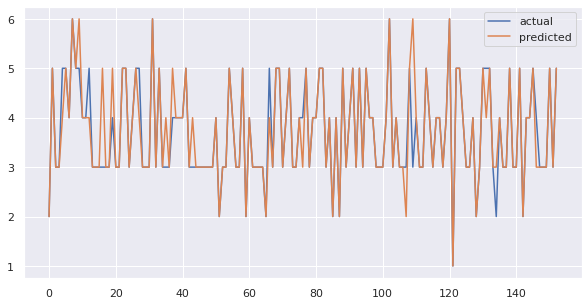

In [21]:
results = pd.DataFrame({'actual': test_labels, 'predicted': pred_rounded})
results.plot(y=['actual', 'predicted'], figsize=(10,5), grid=True)
plt.show()

### Feature selection
In the next step we check the importance of the individual input features:

In [22]:
l = list(zip(features.drop('nrFrontends', axis = 1).columns, rf.feature_importances_))

sorted(l, key = lambda x: x[1], reverse=True) 


[('nrLoadgenerators_1', 0.8258660823861651),
 ('nrFrontends_2', 0.0401388936709137),
 ('lastDecL', 0.03965710058205716),
 ('nrFrontends_1', 0.031759103574338275),
 ('nrFrontends_4', 0.021064821910200364),
 ('nrFrontends_5', 0.01095614029289652),
 ('nrFrontends_3', 0.008072395135061302),
 ('nrLoadgenerators', 0.004641179272377188),
 ('nrLoadgenerators_5', 0.004334202714815116),
 ('loadChange', 0.00376871258379268),
 ('lastIncL', 0.002825303635813496),
 ('nrLoadgenerators_4', 0.002501410512139206),
 ('nrLoadgenerators_3', 0.0016344174034537936),
 ('decL', 0.0013086844262432257),
 ('nrLoadgenerators_2', 0.0009691376549723783),
 ('incL', 0.0005024142447604853)]

As top important features we identify:
* the number of load generators at time i-1
* the number of frontends at time i-2
* the time since the last decline in load
* the number of frontends at time i-1
* the number of frontends at time i-4
* the number of frontends at time i-5

A classifier based on this reduced set of features acheives similar performance:

In [23]:
# Train and evaluate with reduced number of features
features_filtered = features[['nrLoadgenerators_1', 'nrFrontends_2', 'nrFrontends_1', 'lastDecL', 'nrFrontends_4', 'nrFrontends_5']]

feature_list_red = list(features_filtered.columns)
features_filtered = np.array(features_filtered)

#random split 80 20
train_features_red, test_features_red, train_labels_red, test_labels_red = train_test_split(features_filtered, labels, test_size = 0.2, random_state = 42)

rf_red = RandomForestRegressor(n_estimators = 1000, random_state = 42)# Train the model on training data
rf_red.fit(train_features_red, train_labels_red);

In [24]:
predictions_red = rf_red.predict(test_features_red)

pred_rounded_red = np.rint(predictions_red).astype(int)
# Making the Confusion Matrix
print(pd.crosstab(test_labels, pred_rounded_red, rownames=['Actual Frontends'], colnames=['Predicted Frontends'], normalize='index'))

balanced_accuracy_score(test_labels, pred_rounded_red)



Predicted Frontends    1         2         3         4         5         6
Actual Frontends                                                          
1                    1.0  0.000000  0.000000  0.000000  0.000000  0.000000
2                    0.0  0.888889  0.111111  0.000000  0.000000  0.000000
3                    0.0  0.014925  0.910448  0.044776  0.014925  0.014925
4                    0.0  0.000000  0.057143  0.857143  0.085714  0.000000
5                    0.0  0.000000  0.000000  0.108108  0.891892  0.000000
6                    0.0  0.000000  0.000000  0.000000  0.000000  1.000000


0.9247285665196112

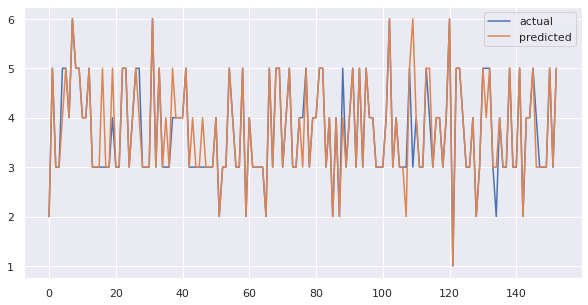

In [25]:
results = pd.DataFrame({'actual': test_labels, 'predicted': pred_rounded_red})
results.plot(y=['actual', 'predicted'], figsize=(10,5), grid=True)
plt.show()